In [10]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

from covid.dataset import fetch_contact_matrix, get_contact_matrices

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
data = fetch_contact_matrix(return_data=True, update=False, force_download=False)
data.head()

,ID,departement,week_day,vacation,age1,sex1,age2,sex2,domicile,ecoles,travailClos,chezProchesLieuxClos,autresLieuxClos(resto..),transport,ouvert,duration
0,15218,59,2,oui,38,femme,68,homme,1,0,0,0,0,0,0,>4h
1,15218,59,2,oui,38,femme,55,femme,1,0,0,0,0,0,0,15-1h
2,15218,59,3,oui,38,femme,68,homme,1,0,0,0,0,0,0,>4h
3,3996,34,5,oui,0,femme,29,homme,1,0,0,0,1,0,1,>4h
4,3996,34,5,oui,0,femme,33,femme,1,0,0,0,0,0,0,1h-4h


## Qu'est-ce qu'un contact ?

Il est difficile de trouver dans la litterature une réponse quand a ce qui caracterise un contact "dangeureux" entre deux personnes.
D'après la note [Soins à domicile pour les patients présumés infectés par le nouveau coronavirus (virus de la COVID-19) qui présentent des symptômes bénins, et prise en charge des contacts](https://apps.who.int/iris/bitstream/handle/10665/331396/WHO-nCov-IPC-HomeCare-2020.2-fre.pdf) de l'OMS, une personne est considérée comme contact dès lors qu’elle a été exposée de l’une des manières suivantes:
* exposition associée aux soins de santé, y compris à la
suite de soins directement dispensés à des patients
atteints de la maladie COVID-19, d’un contact au travail
avec des agents de santé infectés par le virus de la
COVID-19, de visites ou de temps passé dans le même
environnement qu’un patient atteint de COVID-19;
* exposition résultant d’un contact étroit au travail ou en
salle de cours avec un sujet atteint de COVID-19;
* exposition résultant d’un voyage en compagnie d’un
patient atteint de COVID-19, quel que soit le type de
véhicule;
* exposition résultant d’un séjour dans le même foyer
qu’un patient atteint de COVID-19 dans les 14 jours
suivant l’apparition des symptômes chez ce patient. 

Il faut donc un contact étroit et prolongé. Pour l'instant considérons qu'un contact est le fait de réster dans un endroit clos une demi heure. Avec une diminution du risque en milieu ouvert. On peut donc proposer un nombre de contacts par unité de temps en fonction des lieux:

* ecole, Domicile, centreLoisir, autreLieux, transport : 1 contact toute les heures.
* ouvert: 0.2 contact par heure.

On va aussi considérer que les contacts de de <5 minutes durent 5 minutes, 5-15 durent 15 minutes, 15-1h, durent 45 minutes, 1-4h durent 3h, au dela 4h.

In [27]:
data.duration.replace({"<5": 0.08, "5-15": 0.25, "15-1h": 0.75, "1h-4h": 3, ">4h": 4}, inplace=True)
for column in ["domicile", "ecoles", "travailClos", "chezProchesLieuxClos",
           "autresLieuxClos(resto..)", "transport"]:
    data[column] = data[column] * data["duration"]
    
data["ouvert"] = data["ouvert"] * data["duration"] * 0.2

In [28]:
data.head()

,ID,departement,week_day,vacation,age1,sex1,age2,sex2,domicile,ecoles,travailClos,chezProchesLieuxClos,autresLieuxClos(resto..),transport,ouvert,duration
0,15218,59,2,oui,38,femme,68,homme,4.00,0.0,0.0,0.0,0.0,0.0,0.0,4.00
1,15218,59,2,oui,38,femme,55,femme,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.75
2,15218,59,3,oui,38,femme,68,homme,4.00,0.0,0.0,0.0,0.0,0.0,0.0,4.00
3,3996,34,5,oui,0,femme,29,homme,4.00,0.0,0.0,0.0,4.0,0.0,0.8,4.00
4,3996,34,5,oui,0,femme,33,femme,3.00,0.0,0.0,0.0,0.0,0.0,0.0,3.00


## Matrice en moyenne de contacts par jours

In [101]:
vacations = ["oui", "non"]
places = ["domicile", "ecoles", "travailClos", "chezProchesLieuxClos",
         "autresLieuxClos(resto..)", "transport", "ouvert"]
age_groups=[[-1,18], [18,65], [65, np.infty]]

contact_matrices = {place: [] for place in places}

time_select = (data.vacation == "non") 
data_temp = data[time_select]
for Id in data_temp.ID.unique():
    ind = data_temp["ID"] == Id
    age1 =  data_temp.loc[ind,"age1"].mean()
    i = np.where([group[0] < age1 and age1 <= group[1] for group in age_groups])[0].item()
    for place in places:
        matrice = np.zeros((3,3))
        for j in range(3):
            age_group2 = ((age_groups[j][0] < data_temp.age2) & (data_temp.age2 < age_groups[j][1]))
            matrice[i,j] = data_temp.loc[ind & age_group2, place].sum()
        
        contact_matrices[place].append(matrice)
        
contact_matrices = {k:np.mean(v, axis=0) for k,v in contact_matrices.items()}

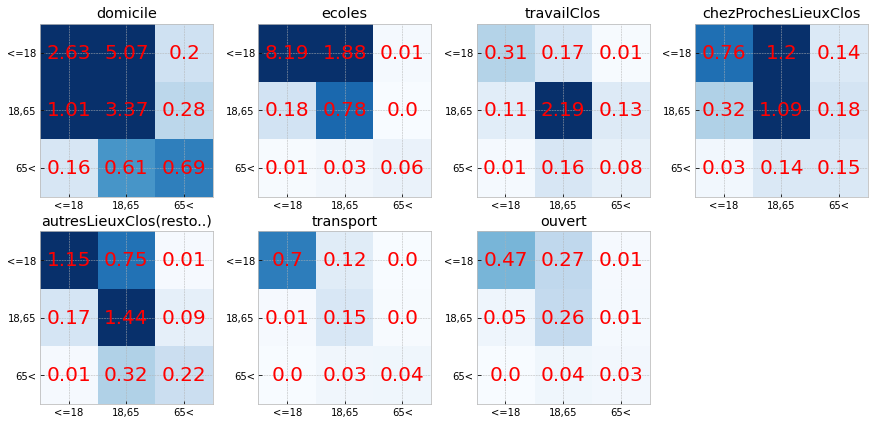

In [109]:
plt.figure(figsize=(15,7))
for i, place in enumerate(places):
    plt.subplot(2,4, i+1)
    plt.imshow(contact_matrices[place], cmap="Blues")
    plt.gca().set_title(place)
    plt.xticks(np.arange(len(age_groups)), ["<=18", "18,65", "65<"])
    plt.yticks(np.arange(len(age_groups)), ["<=18", "18,65", "65<"])
    plt.clim(0,1)

    for i in range(len(age_groups)):
        for j in range(len(age_groups)):
            text = plt.text(j, i, round(contact_matrices[place][i, j], 2),
                           ha="center", va="center", color="r", size=20)

plt.show()


Testing build function

In [114]:
get_contact_matrices()

{'oui': {'domicile': array([[3.21736449, 5.73283178, 0.32054206],
         [1.18123364, 3.55415888, 0.44197196],
         [0.36352336, 0.71159813, 0.69774766]]),
  'ecoles': array([[6.26158879e-01, 4.23757009e-01, 7.47663551e-05],
         [1.06766355e-01, 2.45906542e-01, 0.00000000e+00],
         [0.00000000e+00, 3.84205607e-02, 1.01028037e-02]]),
  'travailClos': array([[2.99457944e-01, 1.68504673e-01, 1.39252336e-03],
         [4.21775701e-02, 1.52666355e+00, 1.92149533e-01],
         [7.00934579e-04, 1.07467290e-01, 2.60747664e-02]]),
  'chezProchesLieuxClos': array([[1.18748598, 2.11861682, 0.37371963],
         [0.26068224, 1.15318692, 0.1807757 ],
         [0.08285047, 0.20114019, 0.13352336]]),
  'autresLieuxClos(resto..)': array([[0.69414953, 1.14013084, 0.05509346],
         [0.2781215 , 1.43065421, 0.11728972],
         [0.00628972, 0.24928037, 0.16819626]]),
  'transport': array([[2.09112150e-01, 1.04411215e-01, 7.47663551e-05],
         [6.00373832e-02, 1.46457944e-01, 1.5

## Matrices de contact au niveau département ? 

In [ ]:
data.groupby("departement").count().rename(columns={"week_day": "count"}).boxplot(column=["count"])

Cela semble compliqué, d'autant que la disparité ne doit pas être importante entre deux départements ayant les mêmes caractéristiques.